In [3]:
# Import
import os
import sys
import shutil

import numpy as np
import math 
import pandas as pd

try:
    import openmm as mm
    import openmm.app as app
    import openmm.unit as unit
except ImportError:
    import simtk.openmm as mm
    import simtk.openmm.app as app
    import simtk.unit as unit
import mdtraj

root_filepath = "C:/Users/Thomas/Documents/workspace/research/OpenABC_RNA"
if root_filepath not in sys.path:
    sys.path.insert(0, root_filepath)

tests_filepath = os.path.join(root_filepath, "tests")
pdbs_filepath = os.path.join(tests_filepath, "pdbs")
runs_filepath = os.path.join(tests_filepath, "runs")

from openabc.forcefields.parsers import SMOGParser
from openabc.forcefields import SMOGSSPNModel
import matplotlib.pyplot as plt

def get_run_id(runs_filepath):
    files = [f for f in os.listdir(runs_filepath) if os.path.isdir(os.path.join(runs_filepath, f))]
    numbers = []
    for file in files:
        try:
            number = int(file)
            numbers.append(number)
        except ValueError:
            continue
    largest_number = max(numbers, default=None)
    if largest_number is not None:
        return f"{largest_number + 1:03d}"
    else:
        return "001"

In this tutorial, we will first take a look at modifications made to the original OpenABC SMOG 3SPN2 architecture to accomodate the SSPN (Single Site Per Nucleotide) coarse graining approach, and then cover the applications. There are four systems:

- $\text{P5GA}$ (pdb id: 1F9L)
- $\text{P5ab}$
- $\text{P5abc}\Delta \text{A}$
- $\text{P5abc}$ (pdb id: 7EZ0)

Since no native structure pdb exists for $\text{P5ab}$ or $\text{P5abc}\Delta \text{A}$, the all-atom structures were made by manually modifying 7EZ0, first by removing residues, and then repositioning residues to connect them. No effort was made to rotate the repositioned residues properly, since it makes little difference to the coarse-grained PDB. The only possible difference is in the native pairing; more on this later.

`smog_parser.py` performs a few functions before coarse-graining:
1. Removes all residues before the first residue with a phosphorus atom. This is because the simulation sites are centered on the phosophorus atom of each residue. Because the phosphorus atom is the heaviest single atom and close to the center of the RNA residue's negative charge density, it makes a good location for the interaction site. However, this means that each system will end up being one nucleotide shorter than in reality; thus the 22-nt hairpin is 21-nt in simulation. This does not appear to make a profound impact on the free-energy landscape, and will make even less of an impact for larger systems.
2. Removes all protein from the PDB. This was a feature is mostly unnecessary, but was left included since the user is intended to be simulating RNA-only systems.

A geometric center, 'gc', option can also be found in `smog_parser.py`.

`parse_mol.py` obtains the information for the forcefield—namely the equilibria for the bonds, angles, and dihedrals. It also uses `find_cg_pairs_from_atomistic_pdb.py` to determine the native pairs through shadow mapping, and their equilibrium lengths.

In [4]:
# Select which system you wish to simulate.
systems = ["1f9l", "P5ab", "P5abcDeltaA", "P5abc"]
system = systems[0]
raw_rna_pdb_filepath = os.path.join(pdbs_filepath, system + '.pdb')
cut_rna_pdb_filepath = os.path.join(pdbs_filepath, system + '_cut.pdb')
cg_rna_pdb_filepath = os.path.join(pdbs_filepath, system + '_cg.pdb')

rna_data = SMOGParser.from_atomistic_pdb(raw_rna_pdb_filepath, cg_rna_pdb_filepath, cut_rna_pdb_filepath, mol_type='rna', cg_type='phosphorus', default_parse=False)
rna_data.parse_mol(get_native_pairs=True, mol_type='rna', bonded_energy_scale=3.75)

Get native pairs with shadow algorithm.
light was not blocked!
light was not blocked!
light was blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was not blocked!
light was not blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was not blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was not blocked!
light was blocked!
light was not blocked!
light was blocked!
light was blocked!
light was not blocked!
light was not blocked!
light was not blocked!
light was not bl

c:\Users\Thomas\miniconda3\envs\ME\Lib\site-packages\mdtraj\formats\pdb\pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


OpenABC is GPU-accelerated, so we expect the user to use GPU. We have added two options for additional potentials which can be used to probe the unfolding kinetics and dynamics: constant force and constant velocity. In both cases, one can imagine the end beads of the system being held in optical traps such as used in [1] (reference). Constant force is effectively biasing the system toward the unfolded state and is used to generate free energy diagrams to observe the transition force, and to determine $\Delta x$ and $\Delta G$. Constant velocity pulls the optical traps apart, ripping the molecule, and can be used to reveal sequential unfolding events. To achieve this, the code increments the equilibrium length between the optical traps every timestep, shifting the traps at a constant velocity, hence the name. To achieve a nice rupturing plot, we recommend a using simulation time of 20 ns for a velocity of 3.0 nm/ns (keeping the optical trap force constant $k$ at 1.4 pN/nm. Ultimately, only the loading rate $v\cdot k$ matters, so the choice of 1.4 is somewhat arbitrary). This will run relatively quickly and show a distinct rupture event for any of the systems. 

In [5]:
# Run Settings
platform_name = 'CUDA'

simulation_time = 0.02 * unit.nanosecond
report_interval = 500
timestep = 10 * unit.femtosecond
temperature = 300*unit.kelvin
friction_coeff = 1.0 / unit.picosecond

add_plumed = False # optional plumed script (empty by default)

do_constant_force = False
constant_force = 12 * unit.piconewton

do_constant_velocity = True
force_extension_velocity = 3.0 * unit.nanometer / unit.nanosecond
force_extension_k = 1.4 * unit.piconewton / unit.nanometer

The following code creates the model, and allows the user to disable/enable any of the components of the forcefield.

In [ ]:
rna_model = SMOGSSPNModel()
rna_model.append_mol(rna_data)
rna_model.atoms_to_pdb(cg_rna_pdb_filepath)
top = app.PDBFile(cg_rna_pdb_filepath).getTopology()
rna_model.create_system(top)
rna_model.add_sspn_bonds(force_group=1)
rna_model.add_sspn_angles(threshold=160*math.pi/180, clip=True, force_group=2)
rna_model.add_sspn_dihedrals(force_group=3)
rna_model.add_native_pairs(force_group=4)
rna_model.exclusions = rna_model.sspn_exclusions
rna_model.add_elec_switch(force_group=6)
rna_model.add_smog_vdwl(force_group=11)
if add_plumed: rna_model.add_plumed("./plumed.dat")
if do_constant_force: rna_model.add_constant_force(constant_force, force_group=13)
if do_constant_velocity: 
    rna_model.add_force_extension(force_extension_k, force_group=14)


C:\Users/Thomas/Documents/workspace/research/OpenABC_RNA\openabc\forcefields\parameters\mixin_3spn2_config_parser.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.bond_definition.loc[flag, 'r0'] = ''
C:\Users/Thomas/Documents/workspace/research/OpenABC_RNA\openabc\forcefields\parameters\mixin_3spn2_config_parser.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.angle_definition.loc[flag2, 'theta0'] = ''
C:\Users/Thomas/Documents/workspace/research/OpenABC_RNA\openabc\forcefields\parameters\mixin_3spn2_config_parser.py:97: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future 

Add sspn bonds.
Decrease all the theta0 values larger than 2.792526803190927 to 2.792526803190927.
Add sspn dihedrals.
Add native pairs.


AttributeError: 'SMOGSSPNModel' object has no attribute 'parse_all_exclusions'

We now set up a place for the simulation files to run. This will create a new run directory within runs, starting from 001, 002, etc. The coarse-grained pdb file is moved there to preserve its exact structure for loading into VMD. Running this cell block multiple times before running the simulation is unnecessary; it does not depend on any of the settings.

In [ ]:
# Initialize

integrator = mm.LangevinMiddleIntegrator(temperature, friction_coeff, timestep)
rna_model.init_coord = app.PDBFile(cg_rna_pdb_filepath).getPositions()
run_id = get_run_id(runs_filepath)
run_filepath = os.path.join(runs_filepath, run_id)
os.makedirs(run_filepath, exist_ok=True)
shutil.copy(cg_rna_pdb_filepath, os.path.join(run_filepath,'structure.pdb'))
trajectory_filepath = os.path.join(run_filepath, "trajectory.dcd")

if do_constant_velocity:
    force_csv_filepath = os.path.join(run_filepath, "force.csv")
    force_csv = open(force_csv_filepath, "w")
    force_csv.write("step,r0_nm,dist_nm,force_pN\n")

rna_model.set_simulation(integrator, platform_name=platform_name, init_coord=rna_model.init_coord)
rna_model.add_reporters(report_interval, output_dcd=trajectory_filepath, report_dcd=True, report_state_data=True)
rna_model.simulation.minimizeEnergy()

Use platform: CUDA
Use precision: mixed


We finally run the simulation. The output is the 'trajectory.dcd' file, which will go into the newly created run directory. The step, time, potential E, kinetic E, total E, temperature, and run speed at each frame of the simulation will be reported live. If constant force is enabled, it will also output `force.csv` which is then used in the plotting of the force-extension curve.

In [ ]:
raw_steps = simulation_time / timestep
report_number = math.ceil(raw_steps / report_interval)
steps = int(report_number * report_interval)

if not do_constant_velocity:
    rna_model.simulation.step(steps)

elif do_constant_velocity:
    first_residue_index, last_residue_index = rna_model.atoms.index[0], rna_model.atoms.index[-1]

    pos = rna_model.simulation.context.getState(getPositions=True).getPositions(asNumpy=True)
    R0_nm = np.linalg.norm((pos[first_residue_index]-pos[last_residue_index]).value_in_unit(unit.nanometer))
    rna_model.simulation.context.setParameter("r0", R0_nm)
    r0_nm = R0_nm

    dr0 = (force_extension_velocity*timestep).value_in_unit(unit.nanometer)
    for step in range(steps):
        r0_nm += dr0
        rna_model.simulation.context.setParameter("r0", r0_nm)
        rna_model.simulation.step(1)
        if step % report_interval == 0:
            st = rna_model.simulation.context.getState(getPositions=True, enforcePeriodicBox=True)
            pos = st.getPositions(asNumpy=True)
            dist_nm = np.linalg.norm((pos[first_residue_index] - pos[last_residue_index]).value_in_unit(unit.nanometer))
            F_pN = force_extension_k.value_in_unit(unit.piconewton / unit.nanometer) * (r0_nm - dist_nm)
            force_csv.write(f"{step},{r0_nm:.4f},{dist_nm:.4f},{F_pN:.4f}\n")
            force_csv.flush()
for reporter in rna_model.simulation.reporters:
    reporter._out.flush()
rna_model.simulation.reporters = None

#"Step","Time (ps)","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Total Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
500,4.999999999999938,12.297512589589832,68.0247919609412,80.32230455053103,272.7167310144633,--
1000,9.999999999999831,8.729857873270639,89.39554814782426,98.1254060210949,358.39377020247434,9.57e+03
1500,14.999999999999725,42.104214838149865,91.11273997403326,133.21695481218313,365.27812703575023,1.04e+04
2000,20.000000000000327,32.811091060563534,58.33330442085945,91.14439548142298,233.86279667070096,1.05e+04


The extension of the molecule (dist_nm in `force.csv`) is a measurement from one end-bead to the other; note that it is different than the distance between the trap equilibria (r0_nm). The force is calculated from the difference between the trap separation, r0_nm, and the end-bead separation, dist_nm, times the force constant. For each system, one should observe a distinct plateu representing a rupturing event. For the full P5abc system, there may be multiple distinct rupturing events. The most prominent usually coincides with P5b unfolding. The plotting will not work if constant velocity was not enabled.

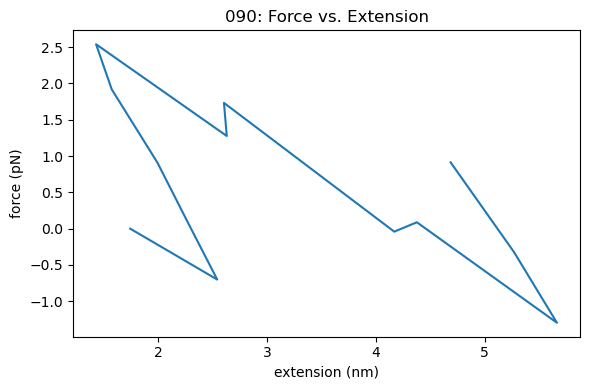

In [25]:
trap_force_path = os.path.join(run_filepath, "force.csv")
img_path = os.path.join(run_filepath, "force.png")
df_trap_force = pd.read_csv(trap_force_path)

plt.figure(figsize=(6, 4))
plt.plot(df_trap_force["dist_nm"], df_trap_force["force_pN"])
plt.xlabel("extension (nm)")
plt.ylabel("force (pN)")
plt.title(f"{run_id}: Force vs. Extension")
plt.tight_layout()
plt.savefig(img_path)
plt.show()

For questions contact trthorn3@ncsu.edu